## **DIP Project**

> Done by Anish Borkar, Aayush Dubey & Godavarthi Sai Nikhil


## Cell Nuclei Segmentation

#### What is a Cell?
A cell is the fundamental unit of life, forming the basis of all living organisms. Cells perform vital functions and can have specialized roles.

#### What is Cell Nuclei Segmentation?
It is the a process of identifying and outlining individual cell nuclei in microscopic images. It allows us to separate and analyze these nuclei.

#### Why Perform Segmentation(Binary Segmentation)?
1. By measuring the size and shape of cells, we determine their health.
2. It helps identify diseased nuclei patterns.
3. Understanding cell responses aids in developing medicines.

#### Introduction:
In our project, we aim to automate cell nuclei segmentation, saving time and enhancing accuracy for researchers.

We’ve all seen people suffer from diseases like cancer, heart disease, chronic obstructive pulmonary disease, Alzheimer’s, and diabetes. Many have seen their loved ones pass away. We can save many lives  if cures came faster. By automating nucleus detection, you could help unlock cures faster

#### Objectives:
1. Implementing a precise U-Net Segmentation model.
2. Minimizing human interfering.
3. Validating results with evaluation metrics.

#### Benefits:
Time savings, increased accuracy, insights into disease, how cells react to various treatments, the researcher can understand the underlying biological processes at work.

#### About Dataset:
Number of Images: 670

Number of Masks: 670

Image Dimensions: 256 X 256 pixels

Image Channels: 3 (RGB)

Dataset Source: https://www.kaggle.com/datasets/84613660e1f97d3b23a89deb1ae6199a0c795ec1f31e2934527a7f7aad7d8c37

### Step 1: Data Loading and Preprocessing
#### 1.1 Data Loading:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
image_dir = '/content/drive/MyDrive/Data/images'
mask_dir = '/content/drive/MyDrive/Data/masks'

image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
mask_paths = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.jpg')]

print("Number of images:", len(image_paths))
print("Number of masks:", len(mask_paths))

Number of images: 670
Number of masks: 670


#### 1.2 Convert images to Grayscale:
To standardize the images, we convert them to grayscale. Bcz grayscale images are often preferred for segmentation tasks due to their simplicity.

In [ ]:
def read_and_preprocess_image(image_path, target_shape):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, target_shape)
    return img

target_shape = (256, 256)
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
preprocessed_images = [read_and_preprocess_image(image_path, target_shape) for image_path in image_paths]

#### 1.3 Normalize pixel values(range [0,1]) and resizing images

In [ ]:
normalized_images = [img / 255.0 for img in preprocessed_images]

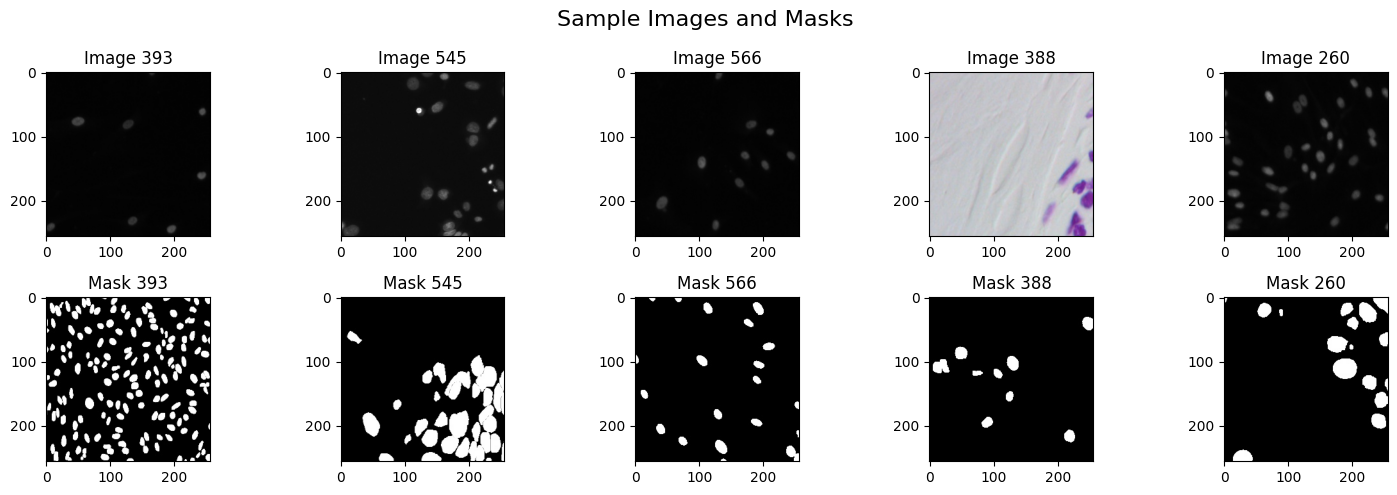

Unique image shapes: {(256, 256, 3)}
Unique mask shapes: {(256, 256, 3)}


In [ ]:
num_samples = 5
sample_indices = np.random.choice(len(image_paths), num_samples, replace=False)

plt.figure(figsize=(15, 5))
plt.suptitle("Sample Images and Masks", fontsize=16)
for i, idx in enumerate(sample_indices):
    img_path = image_paths[idx]
    mask_path = mask_paths[idx]

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {idx + 1}")

    plt.subplot(2, num_samples, i + num_samples + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask {idx + 1}")

plt.tight_layout()
plt.show()

image_shapes = [cv2.imread(img_path).shape for img_path in image_paths]
unique_image_shapes = set(image_shapes)
print("Unique image shapes:", unique_image_shapes)

mask_shapes = [cv2.imread(mask_path).shape for mask_path in mask_paths]
unique_mask_shapes = set(mask_shapes)
print("Unique mask shapes:", unique_mask_shapes)

#### 1.4 Boundary Extraction and Region Filling


Reference For Canny Edge Detection: https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

- identifies edges based on intensity gradients.



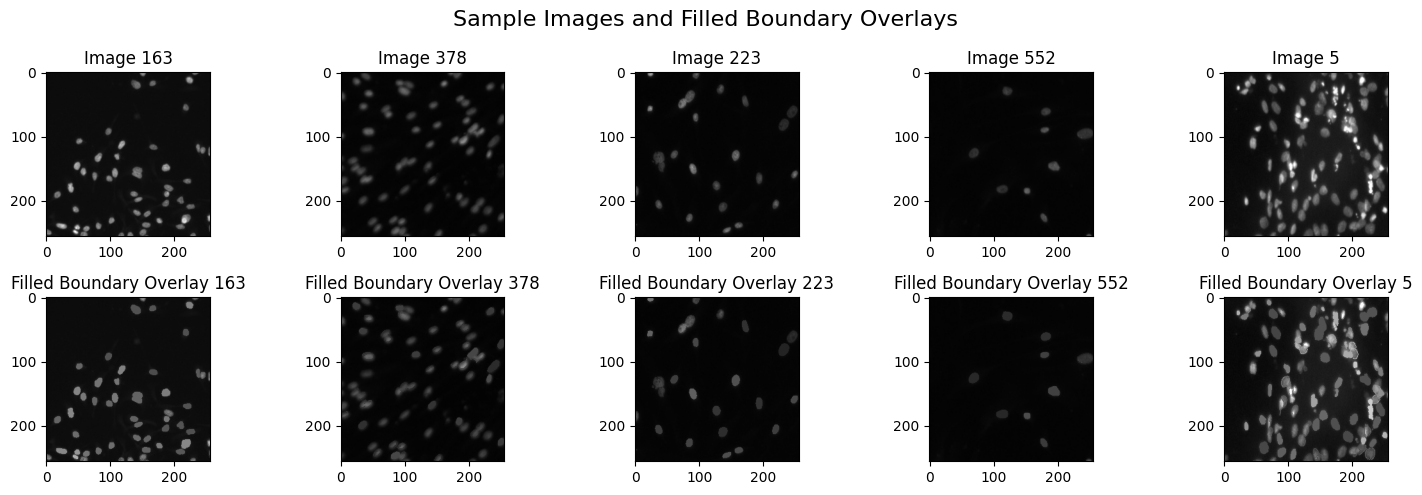

In [ ]:
def extract_and_overlay_boundary(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    mask = np.zeros_like(gray)
    mask[edges != 0] = 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundary_overlay = img.copy()

    for contour in contours:
        mask_roi = np.zeros_like(gray)
        cv2.drawContours(mask_roi, [contour], 0, 255, thickness=cv2.FILLED)
        avg_color = cv2.mean(img, mask=mask_roi)[:3]
        cv2.drawContours(boundary_overlay, [contour], -1, avg_color, thickness=cv2.FILLED)
    return boundary_overlay

image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
preprocessed_images = [read_and_preprocess_image(image_path, target_shape) for image_path in image_paths]
num_samples = 5
sample_indices = np.random.choice(len(image_paths), num_samples, replace=False)
plt.figure(figsize=(15, 5))
plt.suptitle("Sample Images and Filled Boundary Overlays", fontsize=16)

for i, idx in enumerate(sample_indices):
    img_path = image_paths[idx]
    img = cv2.imread(img_path)
    filled_boundary_overlay = extract_and_overlay_boundary(img)
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(img)
    plt.title(f"Image {idx + 1}")
    plt.subplot(2, num_samples, i + num_samples + 1)
    plt.imshow(filled_boundary_overlay)
    plt.title(f"Filled Boundary Overlay {idx + 1}")
plt.tight_layout()
plt.show()

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.int32)
    return ori_x, x

In [ ]:
def save_result(ori_x, ori_y, y_pred, save_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255.0

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_path, cat_images)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

**Model Architecture of U-Net:**

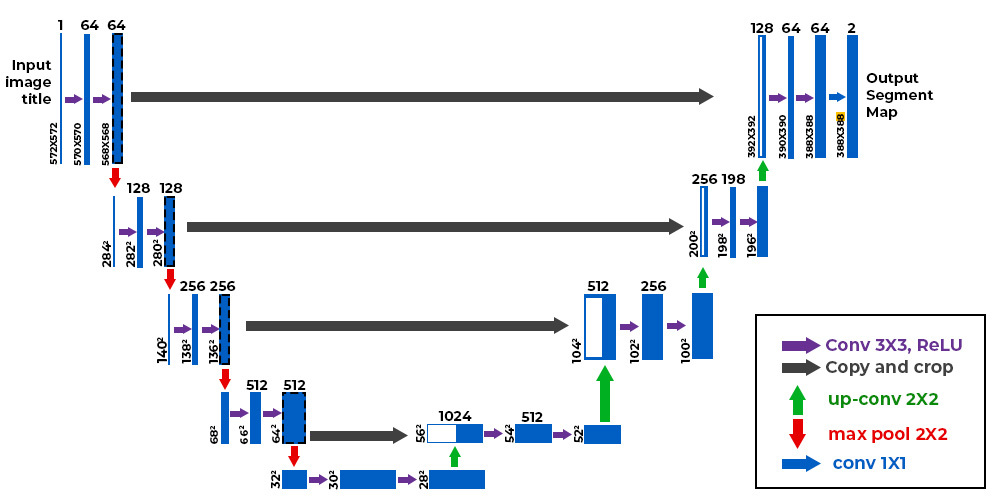

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    s = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(s)
    return s, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="UNET")
    return model

model = build_unet((H, W, 3))
model.summary()


Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 256, 256, 64)         256       ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_36 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_36[0]

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.int32)
    return ori_x, x

**Data Splitting**

In [ ]:

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

def load_data(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.jpg")))
    masks = sorted(glob(os.path.join(path, "masks", "*.jpg")))
    size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

# Load Model
def load_model():
    model_path = "/content/drive/MyDrive/Data/files/model.h5"
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
        model = tf.keras.models.load_model(model_path)
    return model

In [ ]:
def evaluate(model, test_x, test_y):
    create_dir("/content/drive/MyDrive/Data/Generated_Images")
    SCORE = []

    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        name = x.split("/")[-1]

        ori_x, x = read_image(x)
        ori_y, y = read_mask(y)

        y_pred = model.predict(x)[0] > 0.5
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred.astype(np.int32)

        save_path = f"/content/drive/MyDrive/Data/Generated_Images/{name}"
        save_result(ori_x, ori_y, y_pred, save_path)

        y = y.flatten()
        y_pred = y_pred.flatten()

        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")

        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/Data/score.csv")

# Execute the code
np.random.seed(42)
tf.random.set_seed(42)

create_dir("/content/drive/MyDrive/Data/files")

In [ ]:
batch_size = 8
lr = 1e-4
num_epochs = 35

dataset_path = '/content/drive/MyDrive/Data/'
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

train_x, train_y = shuffle(train_x, train_y)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")


Train: 402 - 402
Valid: 134 - 134
Test: 134 - 134


**Training** - For Epochs 35

In [ ]:

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = (len(train_x)//batch_size)
valid_steps = (len(valid_x)//batch_size)

if len(train_x) % batch_size != 0:
    train_steps += 1

if len(valid_x) % batch_size != 0:
    valid_steps += 1

metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss="binary_crossentropy", optimizer=Adam(lr), metrics=metrics)

model_path = "/content/drive/MyDrive/Data/files/model.h5"
csv_path = "/content/drive/MyDrive/Data/files/data.csv"

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/35
51/51 [==============================] - ETA: 0s - loss: 0.3753 - dice_coef: 0.4212 - iou: 0.2736 - recall: 0.6499 - precision: 0.6654
Epoch 1: val_loss improved from inf to 0.65590, saving model to /content/drive/MyDrive/Data/files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 149s 2s/step - loss: 0.3753 - dice_coef: 0.4212 - iou: 0.2736 - recall: 0.6499 - precision: 0.6654 - val_loss: 0.6559 - val_dice_coef: 0.1933 - val_iou: 0.1076 - val_recall: 0.0164 - val_precision: 0.0667 - lr: 1.0000e-04
Epoch 2/35
51/51 [==============================] - ETA: 0s - loss: 0.2131 - dice_coef: 0.5737 - iou: 0.4086 - recall: 0.6391 - precision: 0.8840
Epoch 2: val_loss improved from 0.65590 to 0.54475, saving model to /content/drive/MyDrive/Data/files/model.h5
51/51 [==============================] - 40s 782ms/step - loss: 0.2131 - dice_coef: 0.5737 - iou: 0.4086 - recall: 0.6391 - precision: 0.8840 - val_loss: 0.5447 - val_dice_coef: 0.1906 - val_iou: 0.1059 - val_recall: 5.1723e-06 - val_precision: 0.0920 - lr: 1.0000e-04
Epoch 3/35
51/51 [==============================] - ETA: 0s - loss: 0.1685 - dice_coef: 0.6369 - iou: 0.4734 - recall: 0.6351 - precision: 0.9250
Epoch 3: val_loss improved from 0.54475 to 0.44100, saving model 

In [ ]:
trained_model = load_model()
evaluate(trained_model, test_x, test_y)

  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  1%|          | 1/134 [00:02<05:56,  2.68s/it]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:04<04:11,  1.91s/it]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 3/134 [00:04<02:42,  1.24s/it]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 4/134 [00:04<01:57,  1.10it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:05<01:33,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:05<01:15,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:06<01:08,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:06<01:00,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:06<00:59,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 10/134 [00:07<00:57,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:07<00:54,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 12/134 [00:08<00:49,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 13/134 [00:08<00:50,  2.38it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:08<00:46,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 15/134 [00:09<00:43,  2.75it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:09<00:44,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:09<00:43,  2.69it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 18/134 [00:10<00:47,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:10<00:46,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:11<00:42,  2.66it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:11<00:44,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 22/134 [00:12<00:49,  2.25it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:12<00:55,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 24/134 [00:13<00:58,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 25/134 [00:13<00:57,  1.90it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 26/134 [00:14<00:56,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 27/134 [00:14<00:55,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 28/134 [00:15<00:56,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 29/134 [00:15<00:54,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 30/134 [00:16<00:54,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 31/134 [00:16<00:52,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 32/134 [00:17<00:52,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 33/134 [00:17<00:48,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:18<00:46,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:18<00:42,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 36/134 [00:18<00:40,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:19<00:40,  2.39it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:19<00:38,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:20<00:37,  2.54it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:20<00:38,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:21<00:39,  2.36it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:21<00:39,  2.35it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:21<00:35,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 44/134 [00:22<00:38,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 45/134 [00:22<00:41,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:23<00:40,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:23<00:38,  2.27it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:24<00:36,  2.36it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:24<00:35,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:24<00:35,  2.36it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:25<00:34,  2.38it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 52/134 [00:25<00:32,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:26<00:35,  2.27it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:26<00:34,  2.30it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 55/134 [00:27<00:33,  2.38it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:27<00:33,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 57/134 [00:28<00:36,  2.10it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 58/134 [00:28<00:35,  2.17it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 59/134 [00:29<00:38,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 60/134 [00:29<00:38,  1.93it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 61/134 [00:30<00:37,  1.96it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 62/134 [00:30<00:41,  1.72it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 63/134 [00:31<00:39,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:31<00:38,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 65/134 [00:32<00:34,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:32<00:34,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 67/134 [00:33<00:31,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:33<00:29,  2.25it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:33<00:28,  2.30it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:34<00:27,  2.37it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:34<00:26,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:35<00:26,  2.35it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:35<00:24,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:36<00:26,  2.28it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:36<00:25,  2.28it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:36<00:25,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 77/134 [00:37<00:25,  2.27it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:37<00:24,  2.30it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:38<00:23,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:38<00:21,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:39<00:22,  2.40it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:39<00:24,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:39<00:22,  2.30it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:40<00:21,  2.38it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:40<00:20,  2.44it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:41<00:18,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 87/134 [00:41<00:19,  2.41it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 88/134 [00:42<00:20,  2.28it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 89/134 [00:42<00:19,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 90/134 [00:43<00:21,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 91/134 [00:43<00:21,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 92/134 [00:44<00:21,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 93/134 [00:44<00:21,  1.94it/s]

1/1 [==============================] - 0s 154ms/step


 70%|███████   | 94/134 [00:46<00:32,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 95/134 [00:46<00:27,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:47<00:24,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:47<00:22,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:48<00:19,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:48<00:18,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:48<00:16,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:49<00:15,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:49<00:15,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:50<00:14,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:50<00:14,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:51<00:14,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 106/134 [00:51<00:13,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:52<00:12,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:52<00:11,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:53<00:10,  2.28it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:53<00:10,  2.38it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:53<00:09,  2.54it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:54<00:09,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:54<00:09,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:55<00:09,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:55<00:08,  2.21it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:56<00:07,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 117/134 [00:56<00:07,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 118/134 [00:57<00:07,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 119/134 [00:57<00:08,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 120/134 [00:58<00:07,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 121/134 [00:58<00:06,  1.91it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 122/134 [00:59<00:06,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 123/134 [00:59<00:05,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 124/134 [01:00<00:05,  1.89it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 125/134 [01:00<00:04,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 126/134 [01:01<00:03,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [01:01<00:03,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [01:02<00:02,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [01:02<00:02,  2.37it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [01:02<00:01,  2.21it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 131/134 [01:03<00:01,  2.31it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [01:03<00:00,  2.23it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 133/134 [01:04<00:00,  2.34it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [01:04<00:00,  2.07it/s]

Accuracy: 0.97150
F1: 0.89738
Jaccard: 0.82694
Recall: 0.90449
Precision: 0.90728


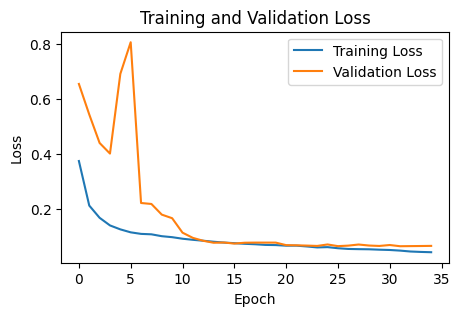

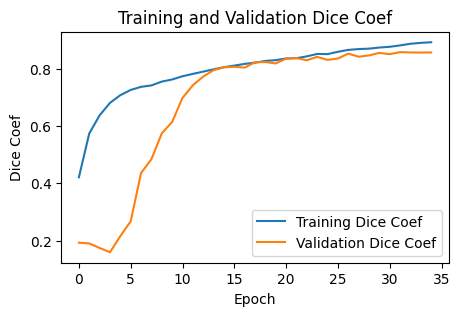

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "/content/drive/MyDrive/Data/files/data.csv"
history_df = pd.read_csv(csv_path)

plt.figure(figsize=(5, 3))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(history_df['dice_coef'], label='Training Dice Coef')
plt.plot(history_df['val_dice_coef'], label='Validation Dice Coef')
plt.title('Training and Validation Dice Coef')
plt.xlabel('Epoch')
plt.ylabel('Dice Coef')
plt.legend()
plt.show()

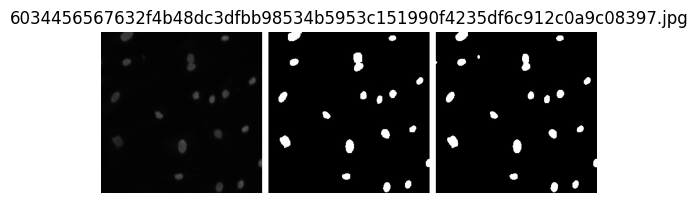

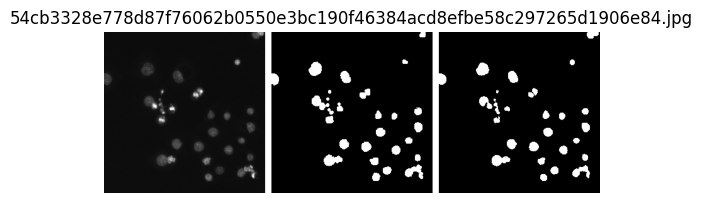

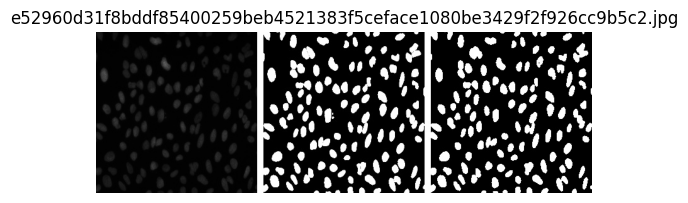

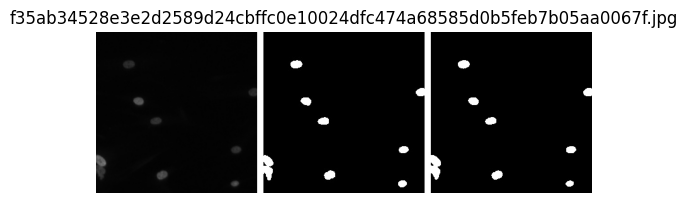

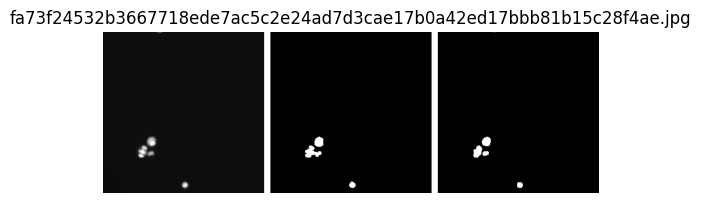

In [ ]:
import os
import matplotlib.pyplot as plt
generated_images_dir = "/content/drive/MyDrive/Data/Generated_Images"
generated_image_files = [f for f in os.listdir(generated_images_dir) if f.endswith('.jpg')]
num_images_to_display = 5
for img_file in generated_image_files[:num_images_to_display]:
    img_path = os.path.join(generated_images_dir, img_file)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis('off')
    plt.show()

For Epochs 10

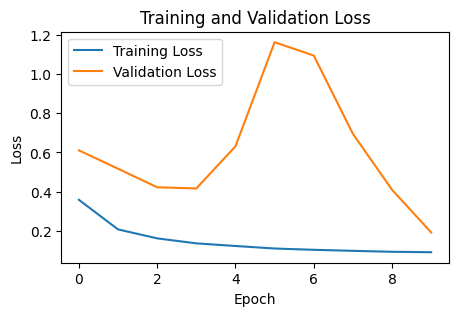

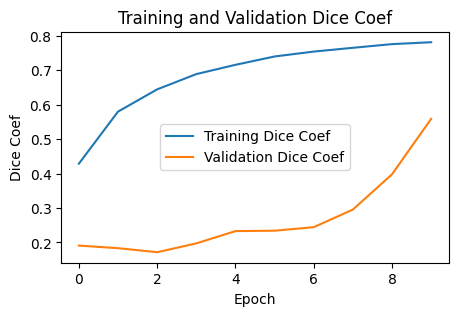

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "/content/drive/MyDrive/Data/file_10/data.csv"
history_df = pd.read_csv(csv_path)

plt.figure(figsize=(5, 3))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(history_df['dice_coef'], label='Training Dice Coef')
plt.plot(history_df['val_dice_coef'], label='Validation Dice Coef')
plt.title('Training and Validation Dice Coef')
plt.xlabel('Epoch')
plt.ylabel('Dice Coef')
plt.legend()
plt.show()

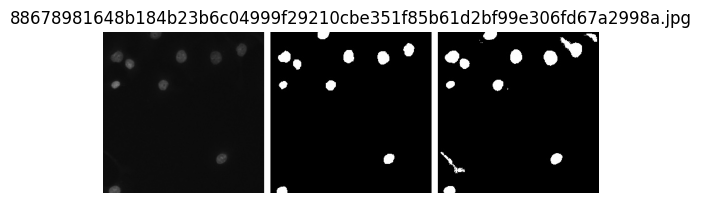

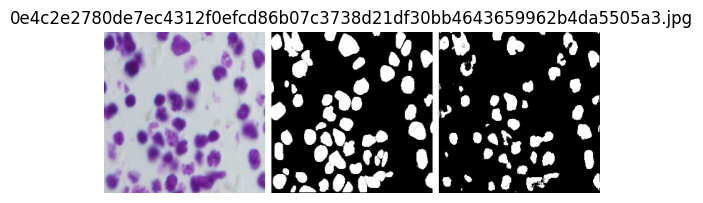

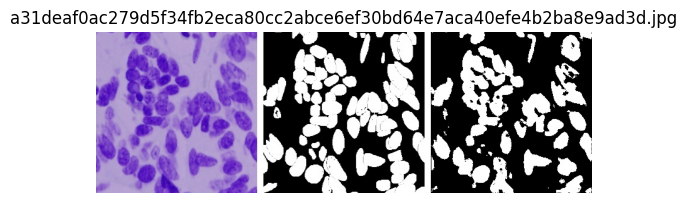

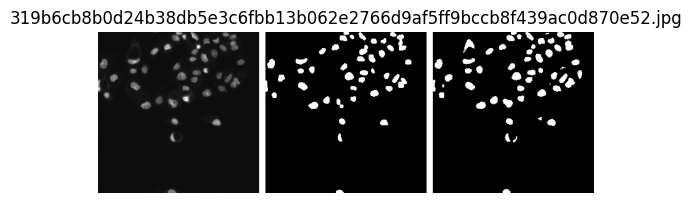

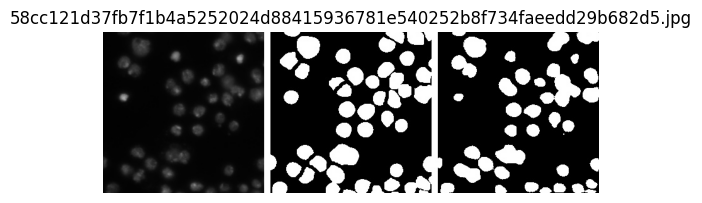

In [ ]:
import os
import matplotlib.pyplot as plt
generated_images_dir = "/content/drive/MyDrive/Data/Generated_Image_10"
generated_image_files = [f for f in os.listdir(generated_images_dir) if f.endswith('.jpg')]
num_images_to_display = 5
for img_file in generated_image_files[:num_images_to_display]:
    img_path = os.path.join(generated_images_dir, img_file)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis('off')
    plt.show()